# Goal
You sit inside the product team at Symantec, which sells a cyber security software for 39 dollars across a variety of devices. Revenue has been flat for some time, so the VP of Product would like to experiment with the effect of increasing the price. Your team designed an experiment to measure the effect of doing so. In the experiment, 66'%' of the users have seen the old price ('$'39), while a random sample of 33 pct of users were shown a higher price (59 dollars).<br><br>
The experiment has been running for some time and the VP of Product is interested in understanding how it went. She would like to learn key insights about what drives conversion rate. She'd like a recommendation of what price to sell the software at, and for you to quantify the cost of the experiment and whether you could have done it in shorter time. Would you have designed the experiment differently, why or why not?

# The data
"test_results" - data about the test<br><br>
Columns:<br><br>
user_id : the Id of the user. Can be joined to user_id in user_table<br><br>
timestamp : the date and time when the user hit for the first time company XYZ webpage. It is in user local time<br><br>
source : marketing channel that led to the user coming to the site. It can be: ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc. seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.<br><br>
friend_referral : user coming from a referral link of another user<br><br>
direct_traffic: user coming by directly typing the address of the site on the browser<br><br>
device : user device. Can be mobile or web<br><br>
operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above<br><br>
test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old, lower price)<br><br>
price : the price the user sees. It should match test<br><br>
converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it)<br><br><br><br>

"user_table" - Information about the user<br><br>
Columns: user_id : the Id of the user. Can be joined to user_id in test_results table<br><br>
city : the city where the user is located. Comes from the user ip address<br><br>
country : in which country the city is located<br><br>
lat : city latitude - should match user city<br><br>
long : city longitude - should match user city<br><br>


# Table of Contents
Data Cleaning<br>
Exploratory Data Analysis<br>
Drilling down into who converted at different price points<br>
Analyzing data over time<br>
Key takeaways<br>

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
import seaborn as sns
%matplotlib inline

## The usual
import data using pandas, investigate the columns and number of rows, investgiate how much missing data there is in these rows

In [2]:
# use pandas to import data
test_results=pd.read_csv(r'C:\Users\Laura\Documents\Insight 2019 Docs\test_results.csv', sep=',',index_col=0)
user_table=pd.read_csv(r'C:\Users\Laura\Documents\Insight 2019 Docs\user_table.csv', sep=',')

In [3]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [4]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 21.8+ MB


In [6]:
test_results.isna().sum()

user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price                   0
converted               0
dtype: int64

In [7]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [8]:
user_table.isna().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [9]:
test_results['user_id'].nunique()

316800

In [10]:
user_table['user_id'].nunique()

275616

### merge the user table and the test results tables together  before further analysis
Note use of outer join to keep test results where we we have a user id but no other information about their city and country

In [11]:
merged_table = pd.merge(test_results, user_table, on='user_id', how='outer')
merged_table.head()
#sort by time stamp
merged_table= merged_table.sort_values('timestamp')

In [12]:
merged_table.isna().sum()

user_id                 0
timestamp             334
source                312
device                  0
operative_system    20339
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [13]:
merged_table.nunique()

user_id             316800
timestamp           141147
source                  12
device                   2
operative_system         8
test                     2
price                 3076
converted                2
city                   923
country                  1
lat                    713
long                   830
dtype: int64

In [14]:
merged_table.describe()

,user_id,test,price,converted,lat,long
count,316800.000000,316800.000000,3.168000e+05,316800.000000,275616.000000,275616.000000
mean,499281.341840,0.360079,6.457590e+06,0.018333,37.111680,-93.981772
std,288591.154044,0.480024,6.797307e+07,0.134154,5.209627,18.086486
min,3.000000,0.000000,3.900000e+01,0.000000,19.700000,-157.800000
25%,249525.750000,0.000000,3.900000e+01,0.000000,33.660000,-112.200000
50%,499021.500000,0.000000,3.900000e+01,0.000000,37.740000,-88.930000
75%,749025.500000,1.000000,5.900000e+01,0.000000,40.700000,-78.910000
max,1000000.000000,1.000000,9.998843e+08,1.000000,61.180000,30.310000


### Ok something weird is going on with price and we have some weirdly high values...
We already know that there are 2 prices possible (39 and 59 dollars) for 0 and 1. We can recode these values and generate a new variable for price.

In [15]:
merged_table['price'].unique()

array([5.90000000e+01, 3.90000000e+01, 5.47880294e+08, ...,
       3.36576957e+08, 4.34655875e+08, 8.48064501e+08])

In [16]:
merged_table[merged_table['price']>=60].head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
123034,935819,2015-03-02 01:56:20,ads_other,web,windows,0,547880294.0,0,Sugar Land,USA,29.62,-95.62
85132,695470,2015-03-02 02:37:47,ads-google,web,windows,1,793744486.0,0,Missouri City,USA,29.57,-95.54
28421,825645,2015-03-02 02:46:25,ads_facebook,mobile,android,1,858834925.0,0,Seattle,USA,47.62,-122.35
150806,348641,2015-03-02 06:48:16,ads_other,mobile,iOS,1,783425156.0,0,Euless,USA,32.85,-97.08
85874,525514,2015-03-02 06:55:01,direct_traffic,mobile,android,0,790043641.0,0,Edina,USA,44.89,-93.36


In [17]:
# apply lambda function to generate a new variable for price based on converted
merged_table['price_mod'] =  merged_table['test'].apply(lambda x: 39 if x==0 else 59)

In [18]:
merged_table.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod
166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,Plymouth,USA,45.02,-93.46,59
215757,813537,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,NaN,NaN,NaN,NaN,59
20240,583796,2015-03-02 00:12:40,ads_facebook,web,windows,0,39.0,0,Jacksonville,USA,30.33,-81.66,39
278620,632922,2015-03-02 00:16:25,ads-google,web,windows,0,39.0,0,Virginia Beach,USA,36.74,-76.04,39
271250,866803,2015-03-02 00:18:46,direct_traffic,web,mac,0,39.0,0,North Port,USA,27.05,-82.19,39


In [19]:
#way better
merged_table.nunique()

user_id             316800
timestamp           141147
source                  12
device                   2
operative_system         8
test                     2
price                 3076
converted                2
city                   923
country                  1
lat                    713
long                   830
price_mod                2
dtype: int64

[None, None]

<Figure size 1080x1080 with 0 Axes>

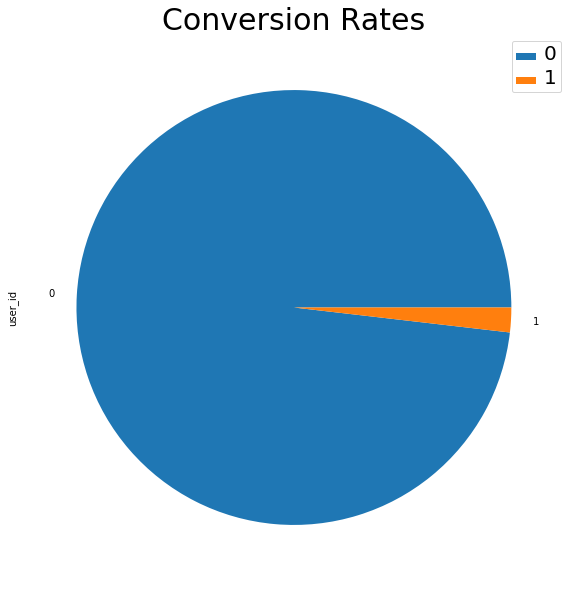

In [20]:
# how many people converted?
#how many by price?
pies=merged_table.groupby('converted').count()
plt.figure(figsize=(15,15))
plot = pies.plot.pie(y='user_id', figsize=(10, 10))
plot.set_title("Conversion Rates", fontsize=30)
plot.tick_params(labelsize=30)
plt.setp(plot.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(plot.get_legend().get_title(), fontsize='20') # for legend title
#plt.savefig("happypie.png")

In [21]:
merged_table.groupby('converted').count()

,user_id,timestamp,source,device,operative_system,test,price,city,country,lat,long,price_mod
converted,,,,,,,,,,,,
0,310992,310663,310681,310992,290897,310992,310992,270597,270597,270597,270597,310992
1,5808,5803,5807,5808,5564,5808,5808,5019,5019,5019,5019,5808


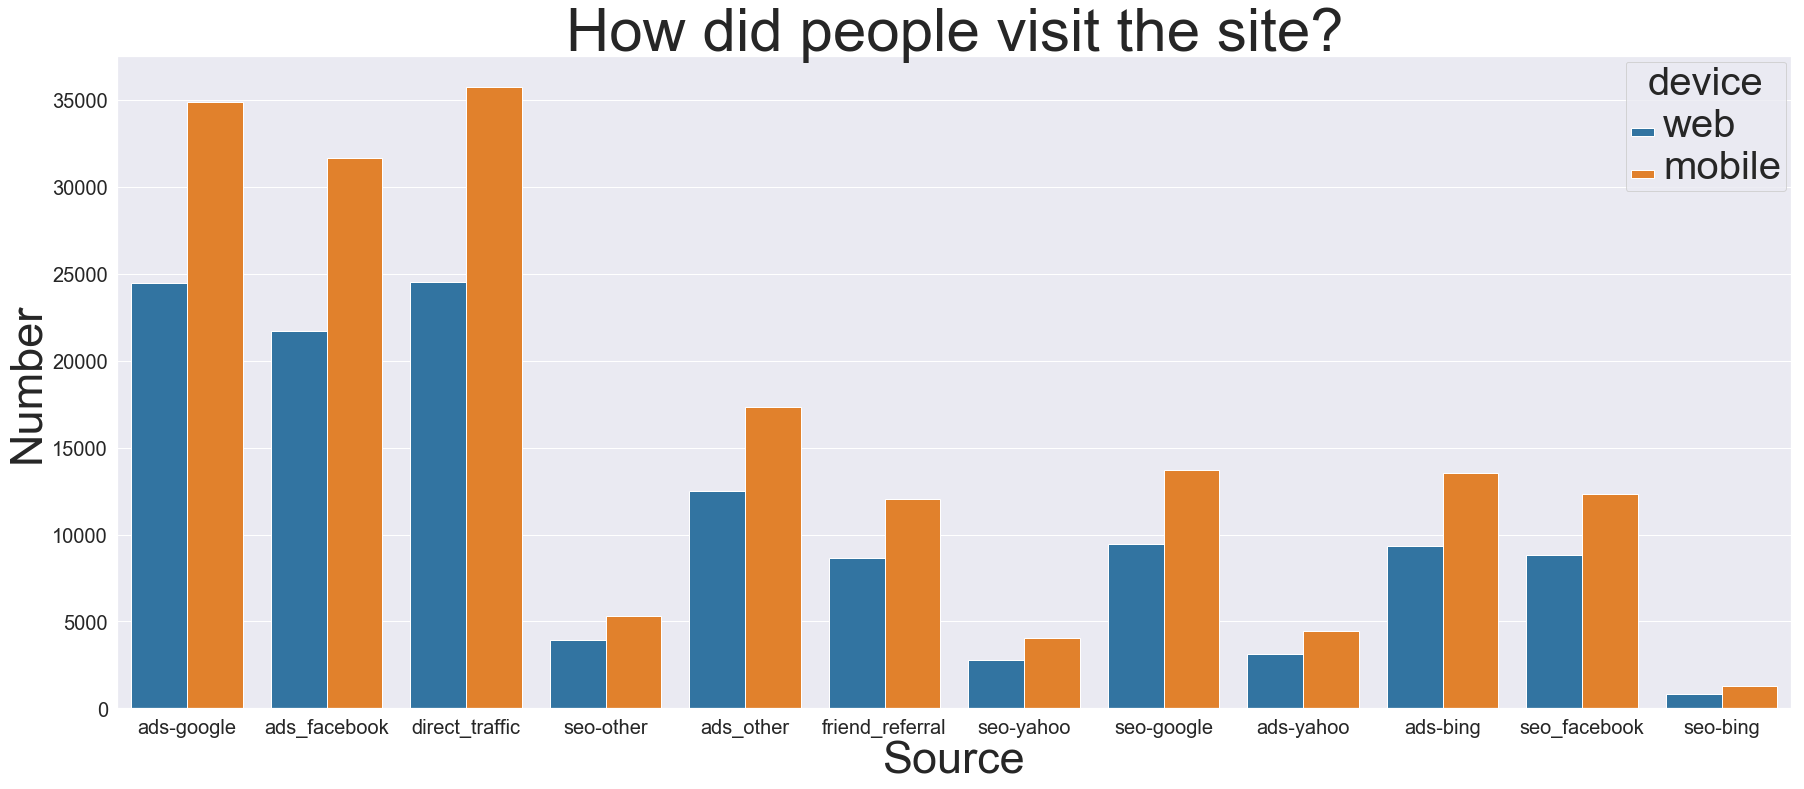

In [22]:
#countplot by device
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.countplot(x='source', hue='device', data=merged_table)
ax.set_title("How did people visit the site?", fontsize=60)
ax.set_xlabel("Source", fontsize=45)
ax.set_ylabel("Number", fontsize=45)
plt.setp(ax.get_legend().get_texts(), fontsize='40') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='40') # for legend title
ax.tick_params(labelsize=20)
plt.savefig("source-device.png")

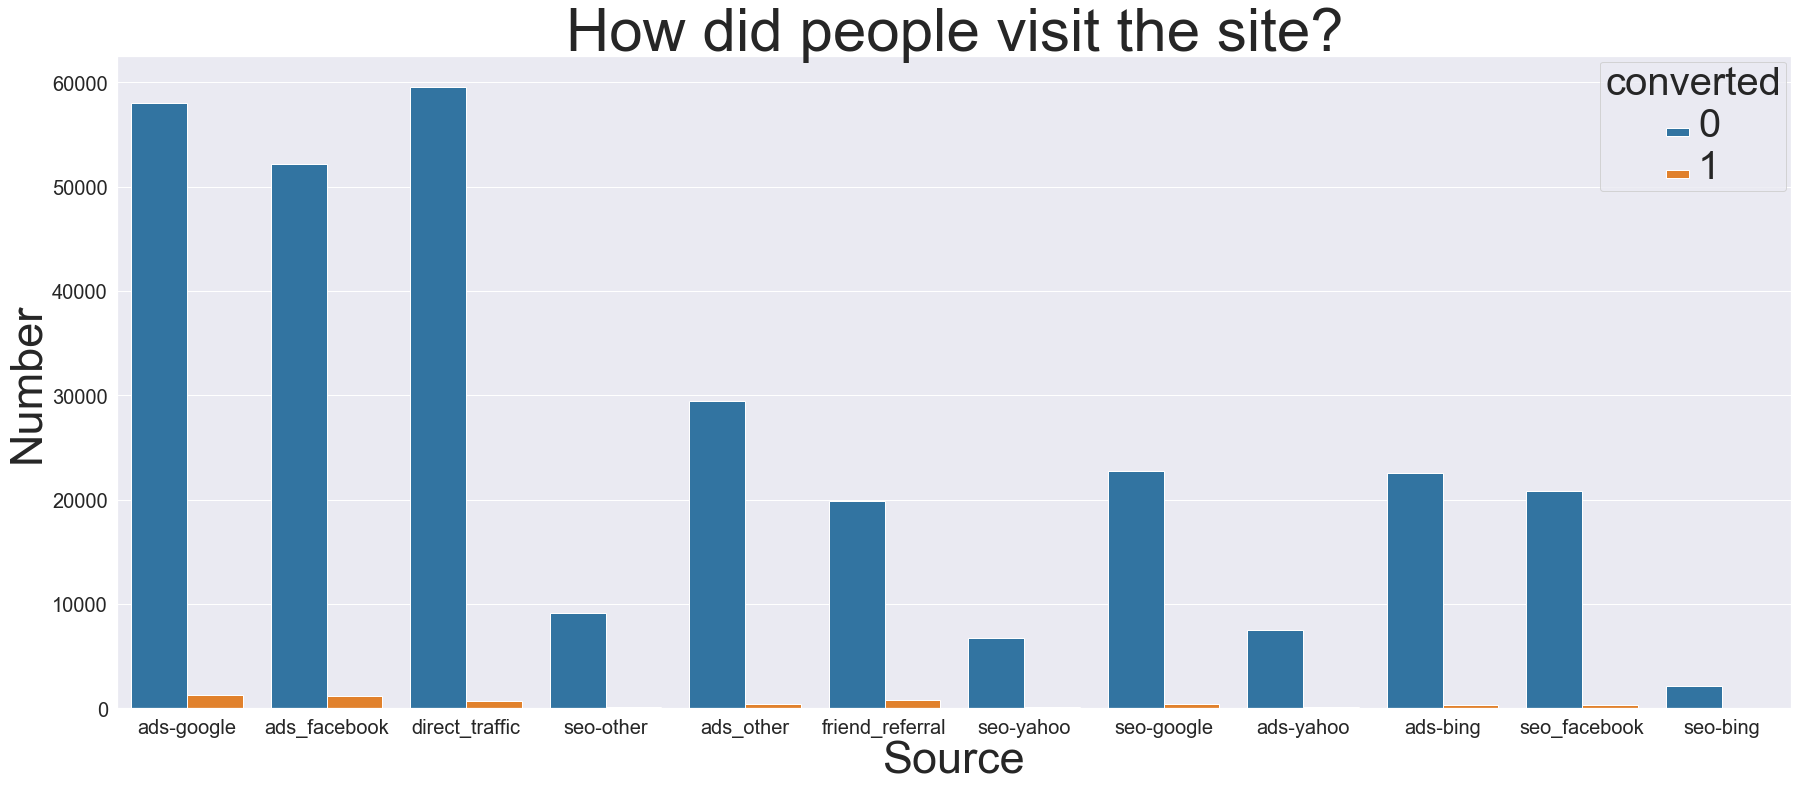

In [23]:
#countplot of devices
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.countplot(x='source', hue='converted', data=merged_table)
ax.set_title("How did people visit the site?", fontsize=60)
ax.set_xlabel("Source", fontsize=45)
ax.set_ylabel("Number", fontsize=45)
plt.setp(ax.get_legend().get_texts(), fontsize='40') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='40') # for legend title
ax.tick_params(labelsize=20)
plt.savefig("convert-device.png")

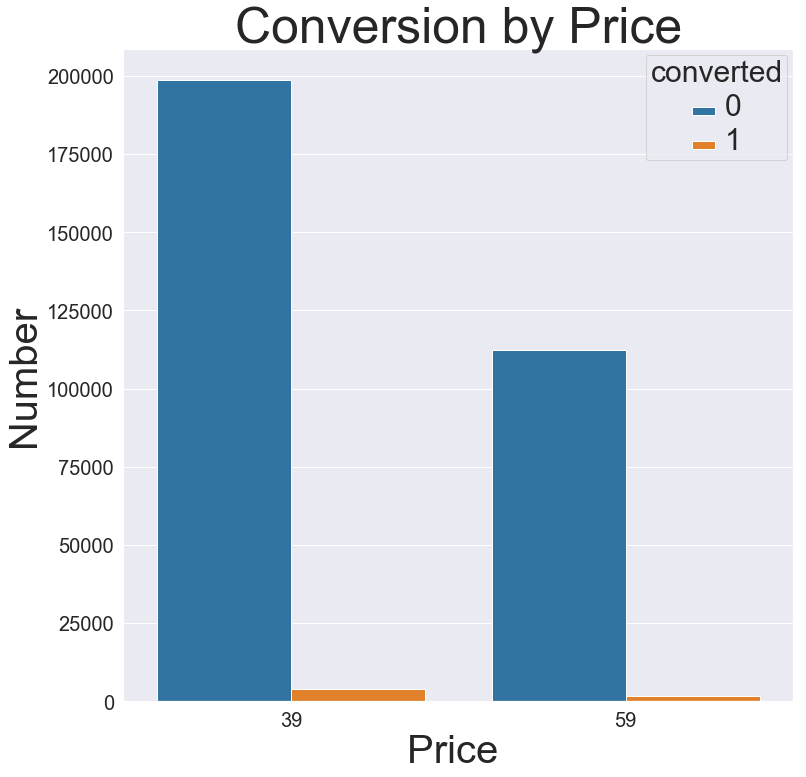

In [24]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(12,12))
ax=sns.countplot(x='price_mod', hue='converted', data=merged_table)
ax.set_title("Conversion by Price", fontsize=50)
ax.set_xlabel("Price ", fontsize=40)
ax.set_ylabel("Number", fontsize=40)
plt.setp(ax.get_legend().get_texts(), fontsize='30') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='30') # for legend title
ax.tick_params(labelsize=20)
plt.savefig("convert-price.png")

## Now we have to go fix some funky issues with operating system
There are some funny misspellings here for android and and windows, and we can just call apple as mac

In [25]:
merged_table.groupby('operative_system').count()

,user_id,timestamp,source,device,test,price,converted,city,country,lat,long,price_mod
operative_system,,,,,,,,,,,,
android,74856,74766,74782,74856,74856,74856,74856,65236,65236,65236,65236,74856
anroid,79,79,78,79,79,79,79,69,69,69,69,79
apple,29,29,29,29,29,29,29,23,23,23,23,29
i0S,113,113,113,113,113,113,113,100,100,100,100,113
iOS,95352,95251,95263,95352,95352,95352,95352,82882,82882,82882,82882,95352
mac,25056,25030,25028,25056,25056,25056,25056,21808,21808,21808,21808,25056
windows,100878,100774,100771,100878,100878,100878,100878,87637,87637,87637,87637,100878
wnddows,98,98,98,98,98,98,98,84,84,84,84,98


Applying a lambda function to create a new column for operating system

In [26]:
# apply lambda function to generate a new variable for misspelled operating system names (geez, who spelled these?)
merged_table['os_mod'] =  merged_table['operative_system']
merged_table['os_mod'] =  merged_table['os_mod'].apply(lambda x: 'iOS' if x=='i0S' else x)
merged_table['os_mod'] =  merged_table['os_mod'].apply(lambda x: 'android' if x=='anroid' else x)
merged_table['os_mod'] =  merged_table['os_mod'].apply(lambda x: 'mac' if x=='apple' else x)
merged_table['os_mod'] =  merged_table['os_mod'].apply(lambda x: 'windows' if x=='wnddows' else x)

In [27]:
merged_table.groupby('os_mod').count()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod
os_mod,,,,,,,,,,,,,
android,74935,74845,74860,74935,74935,74935,74935,74935,65305,65305,65305,65305,74935
iOS,95465,95364,95376,95465,95465,95465,95465,95465,82982,82982,82982,82982,95465
mac,25085,25059,25057,25085,25085,25085,25085,25085,21831,21831,21831,21831,25085
windows,100976,100872,100869,100976,100976,100976,100976,100976,87721,87721,87721,87721,100976


# Exploratory data visualization
We are looking to see where conversion rates are highest, or largest sources of conversion

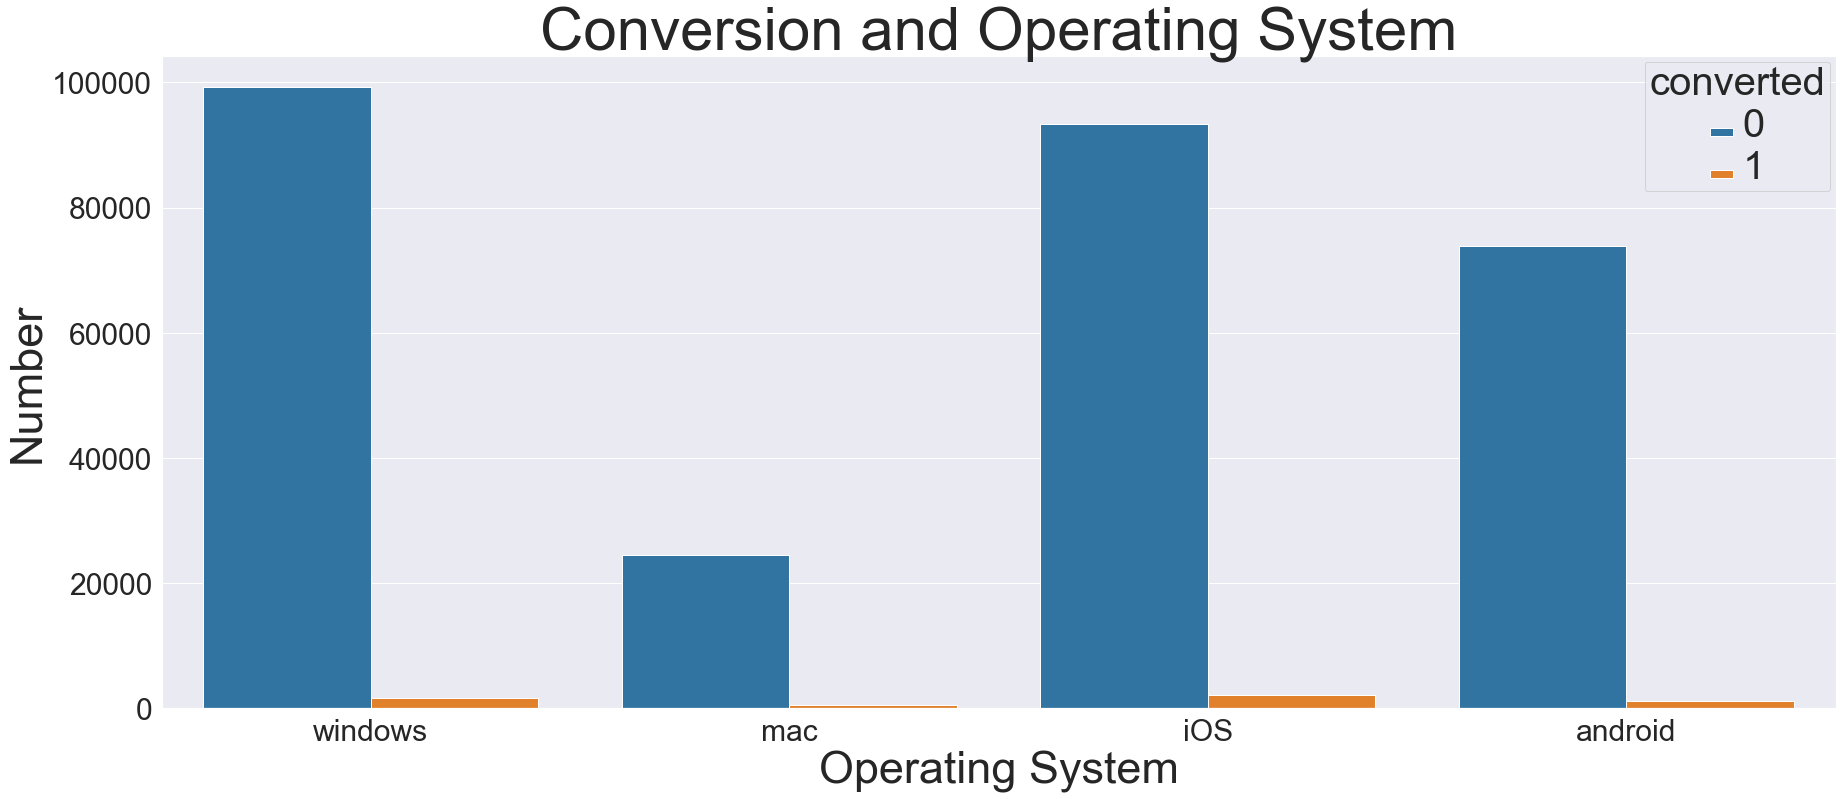

In [28]:
#operating system
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.countplot(x='os_mod', hue='converted', data=merged_table)
ax.set_title("Conversion and Operating System", fontsize=60)
ax.set_xlabel("Operating System", fontsize=45)
ax.set_ylabel("Number", fontsize=45)
plt.setp(ax.get_legend().get_texts(), fontsize='40') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='40') # for legend title
ax.tick_params(labelsize=30)
plt.savefig("conversystem-os.png")

In [29]:
#cross tab by price and convert to quantify costs
#check out timestamp
merged_table['timestamp'].unique()


array(['2015-03-02 00:04:12', '2015-03-02 00:12:40',
       '2015-03-02 00:16:25', ..., '2815-05-30 19:43:18',
       '2815-05-31 12:18:52', nan], dtype=object)

In [30]:
#cross tab of price with column percentages 
price_convert_xtab=pd.crosstab(merged_table['converted'],merged_table['price_mod']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
price_convert_xtab

price_mod,39,59
converted,,
0,98.01,98.45
1,1.99,1.55


In [31]:
df1=pd.DataFrame(price_convert_xtab.iloc[1])
df1.columns = ['pct']
df1

,pct
price_mod,
39,1.99
59,1.55


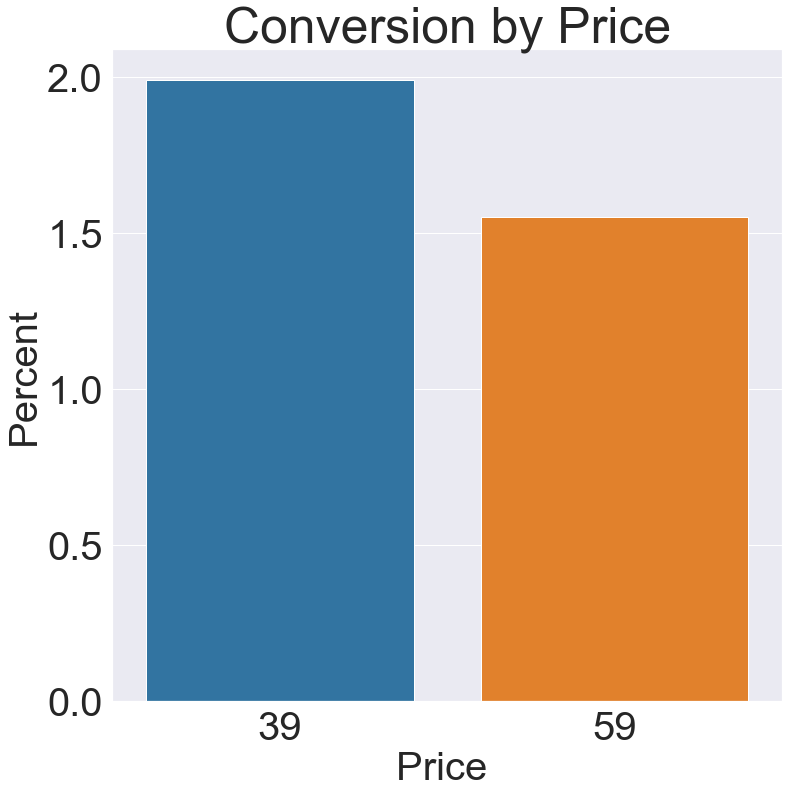

In [32]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(12,12))
ax=sns.barplot(x=df1.index ,y='pct', data=df1)
ax.set_title("Conversion by Price", fontsize=50)
ax.set_xlabel("Price ", fontsize=40)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=40)
plt.savefig("convert-price-pct.png")

In [33]:
pd.crosstab(merged_table['converted'],merged_table['price_mod'], margins=True)

price_mod,39,59,All
converted,,,
0,198692,112300,310992
1,4035,1773,5808
All,202727,114073,316800


In [34]:
#cross tab of place
#highest percentage of  convrsion comes from friend referral, with slightly better results from google, fb ads, bing SEO
source_convert_xtab=pd.crosstab(merged_table['converted'],merged_table['source']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df2=pd.DataFrame(source_convert_xtab.iloc[1])
df2.columns = ['pct']
df2

,pct
source,
ads-bing,1.20
ads-google,2.15
ads-yahoo,1.48
ads_facebook,2.12
ads_other,1.44
direct_traffic,1.23
friend_referral,3.87
seo-bing,2.37
seo-google,1.70


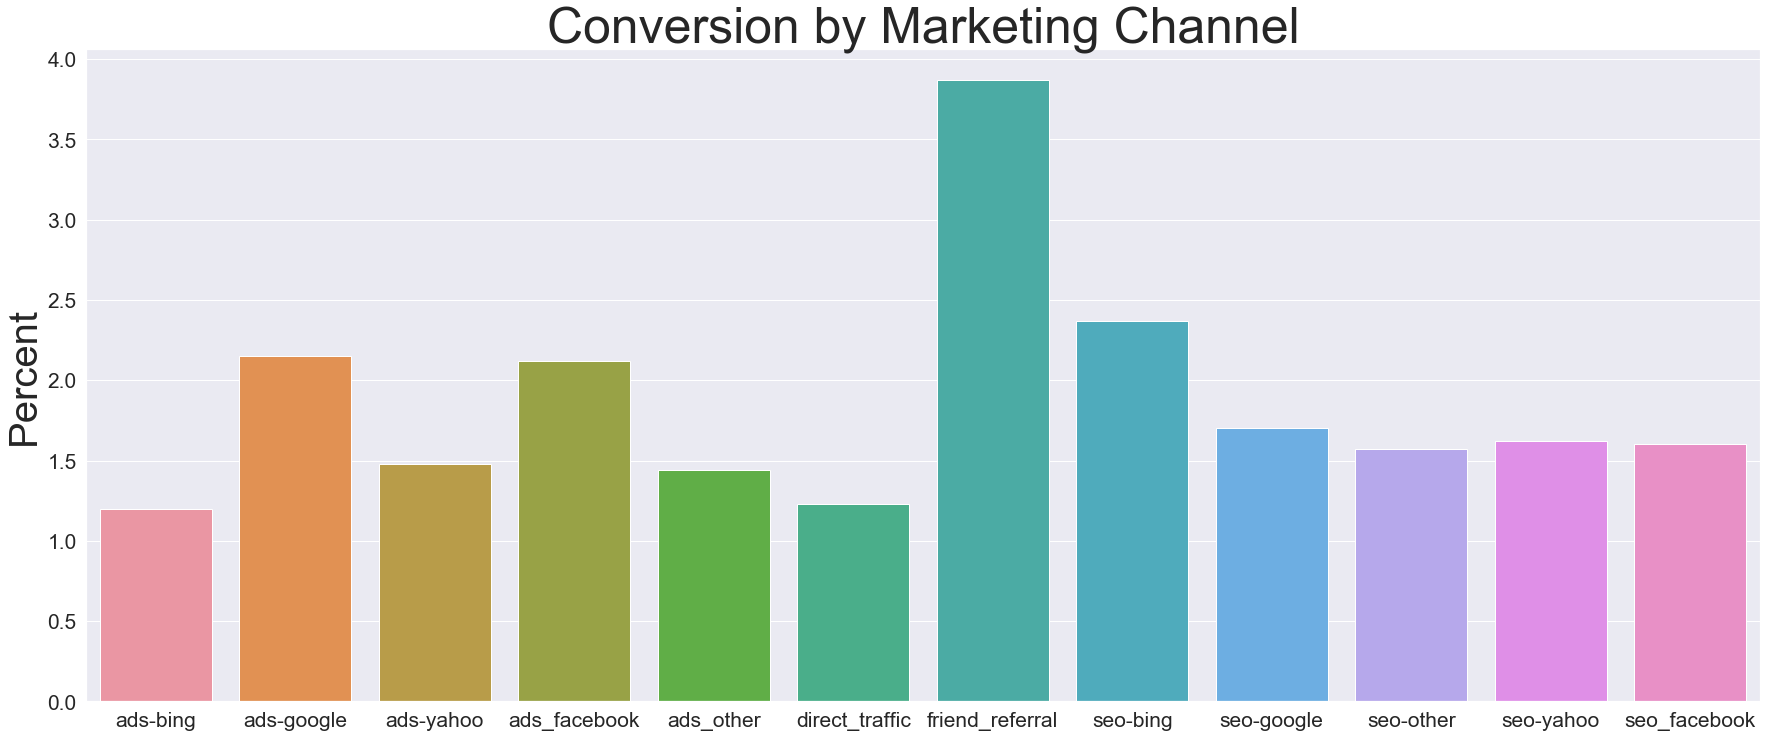

In [35]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df2.index ,y='pct', data=df2)
ax.set_title("Conversion by Marketing Channel", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=21)
plt.savefig("convert-source-pct.png")

In [36]:
pd.crosstab(merged_table['converted'],merged_table['source'])

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
converted,,,,,,,,,,,,
0,22577,58043,7461,52205,29420,59564,19872,2098,22766,9105,6725,20845
1,274,1276,112,1132,429,743,800,51,394,145,111,340


In [37]:
#cross tab of device
pd.crosstab(merged_table['converted'],merged_table['device']).apply(lambda r: round((r/r.sum())*100,2), axis=0)

device,mobile,web
converted,,
0,98.14,98.2
1,1.86,1.8


In [38]:
#cross tab of os
#best rates by mac and iOS (aka apple products)
os_convert_xtab=pd.crosstab(merged_table['converted'],merged_table['os_mod']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df3=pd.DataFrame(os_convert_xtab.iloc[1])
df3.columns = ['pct']
df3

,pct
os_mod,
android,1.49
iOS,2.23
mac,2.40
windows,1.70


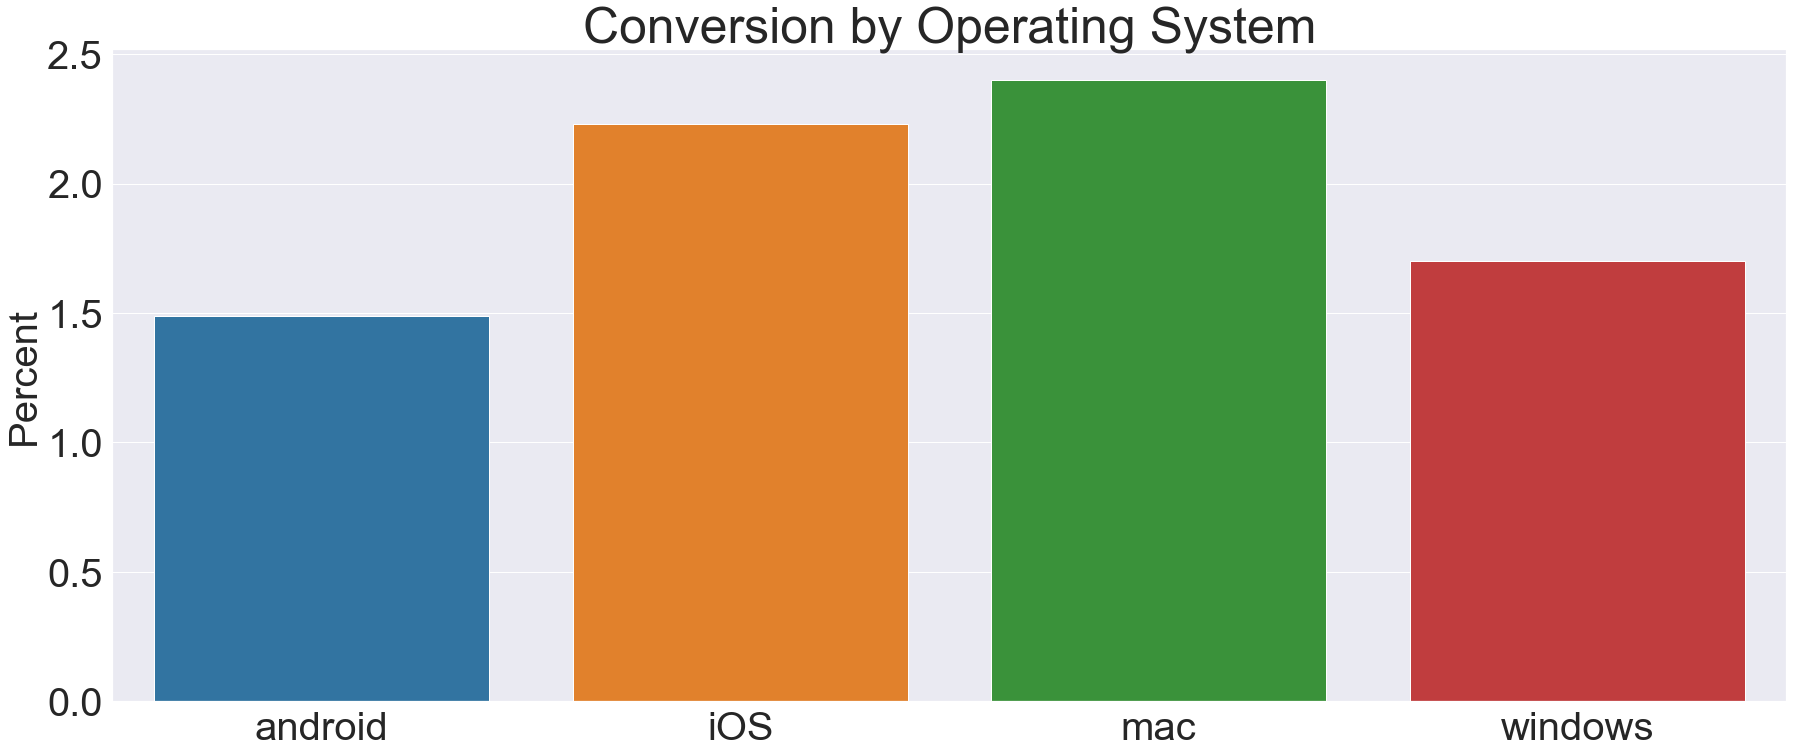

In [39]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df3.index ,y='pct', data=df3)
ax.set_title("Conversion by Operating System", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=40)
plt.savefig("convert-os-pct.png")

In [40]:
#cross tab of os
#best rates by mac and iOS (aka apple products)
pd.crosstab(merged_table['converted'],merged_table['device']).apply(lambda r: round((r/r.sum())*100,2), axis=0)

device,mobile,web
converted,,
0,98.14,98.2
1,1.86,1.8


In [41]:
#lol just checking here that iOS=mobile and mac=web
pd.crosstab(merged_table['os_mod'],merged_table['device'])

device,mobile,web
os_mod,,
android,74935,0
iOS,95465,0
mac,0,25085
windows,0,100976


# drilling down into who converted at 39 and who converted at 59
First we will separate out test results by price (39 and 59) and the repeat what we did before hand

In [42]:
converted59=merged_table[merged_table['price_mod']==59]
converted39=merged_table[merged_table['price_mod']==39]

In [43]:
cv_source_xtab59=pd.crosstab(converted59['converted'],merged_table['source']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df4=pd.DataFrame(cv_source_xtab59.iloc[1])
df4.columns = ['pct']
df4

,pct
source,
ads-bing,0.96
ads-google,1.96
ads-yahoo,1.12
ads_facebook,1.69
ads_other,1.25
direct_traffic,1.01
friend_referral,3.34
seo-bing,1.34
seo-google,1.60


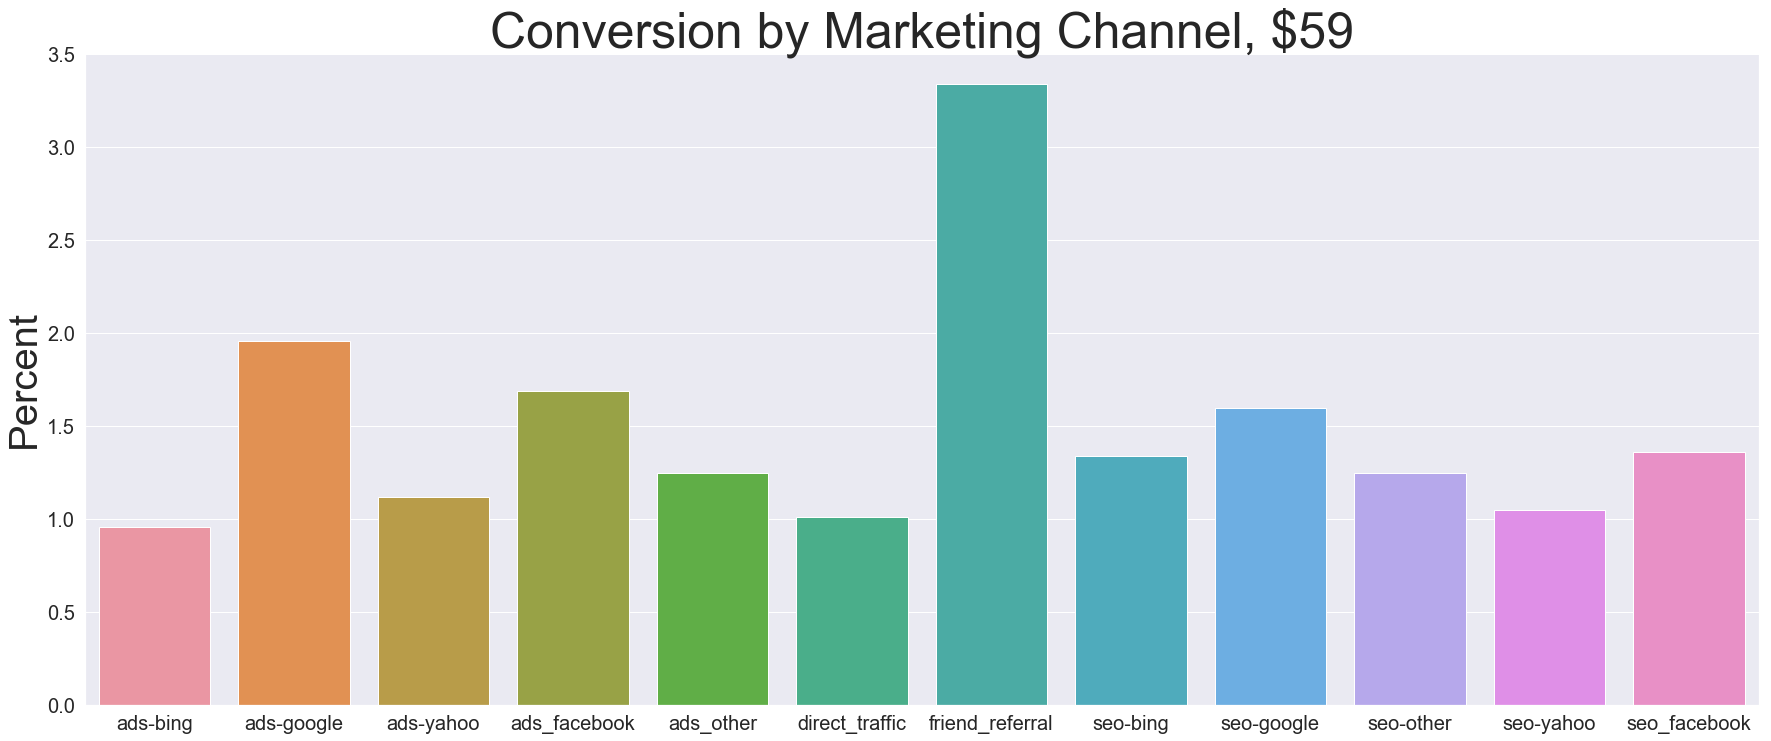

In [44]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df4.index ,y='pct', data=df4)
ax.set_title("Conversion by Marketing Channel, $59", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=20)
plt.savefig("convert-59-pct.png")

In [45]:
cv_source_xtab39=pd.crosstab(converted39['converted'],merged_table['source']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df5=pd.DataFrame(cv_source_xtab39.iloc[1])
df5.columns = ['pct']
df5

,pct
source,
ads-bing,1.34
ads-google,2.26
ads-yahoo,1.68
ads_facebook,2.37
ads_other,1.54
direct_traffic,1.36
friend_referral,4.18
seo-bing,3.01
seo-google,1.76


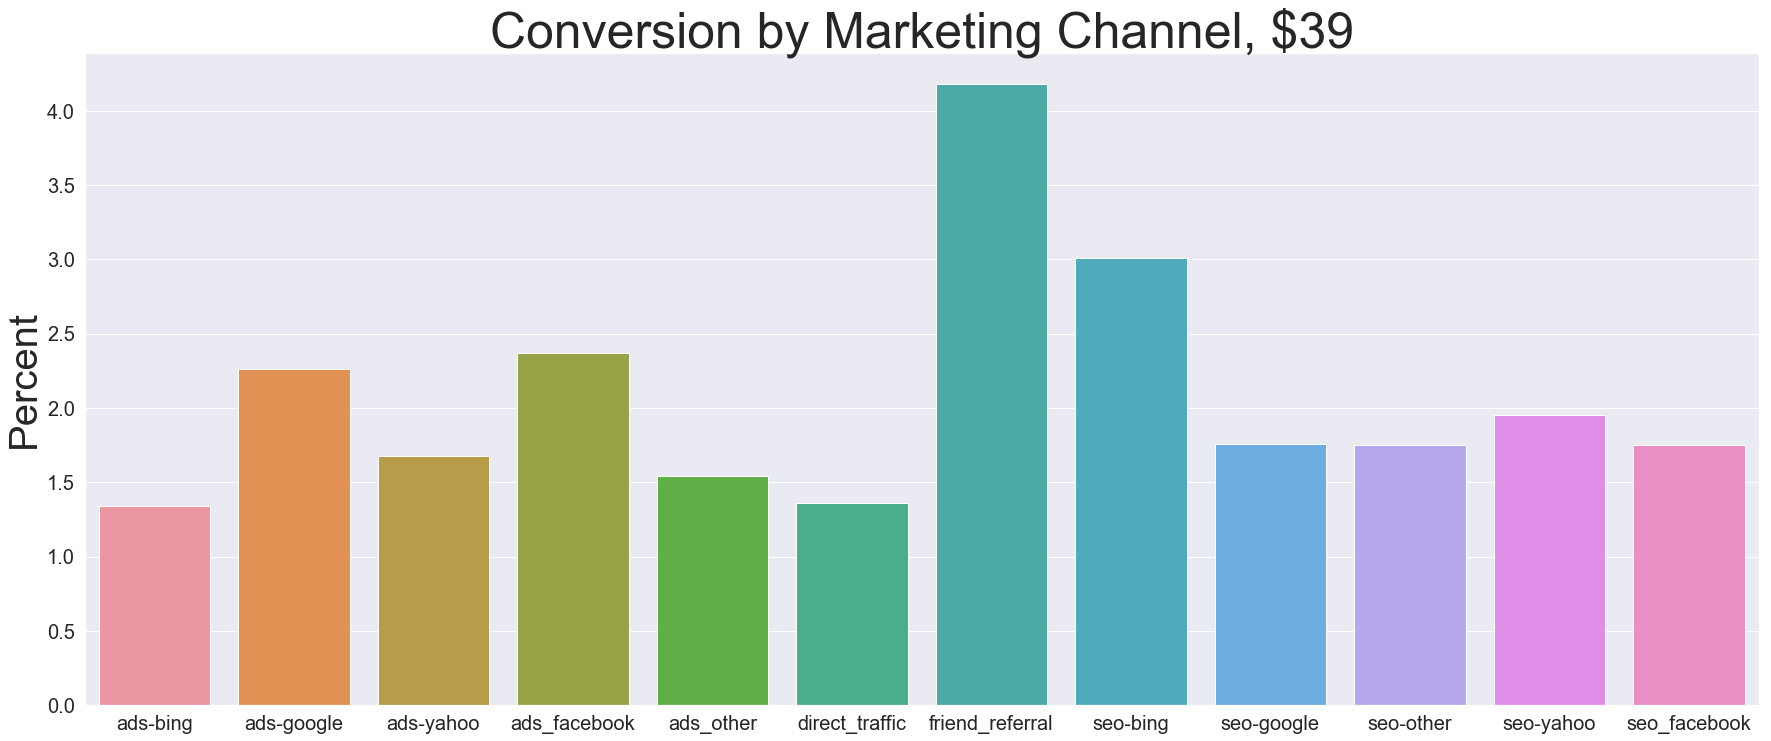

In [46]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df5.index ,y='pct', data=df5)
ax.set_title("Conversion by Marketing Channel, $39", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=20)
plt.savefig("convert-39-pct.png")

In [47]:
#conversion by OS $39
cv_os_xtab39=pd.crosstab(converted39['converted'],converted39['os_mod']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df6=pd.DataFrame(cv_os_xtab39.iloc[1])
df6.columns = ['pct']
df6

,pct
os_mod,
android,1.64
iOS,2.36
mac,2.55
windows,1.87


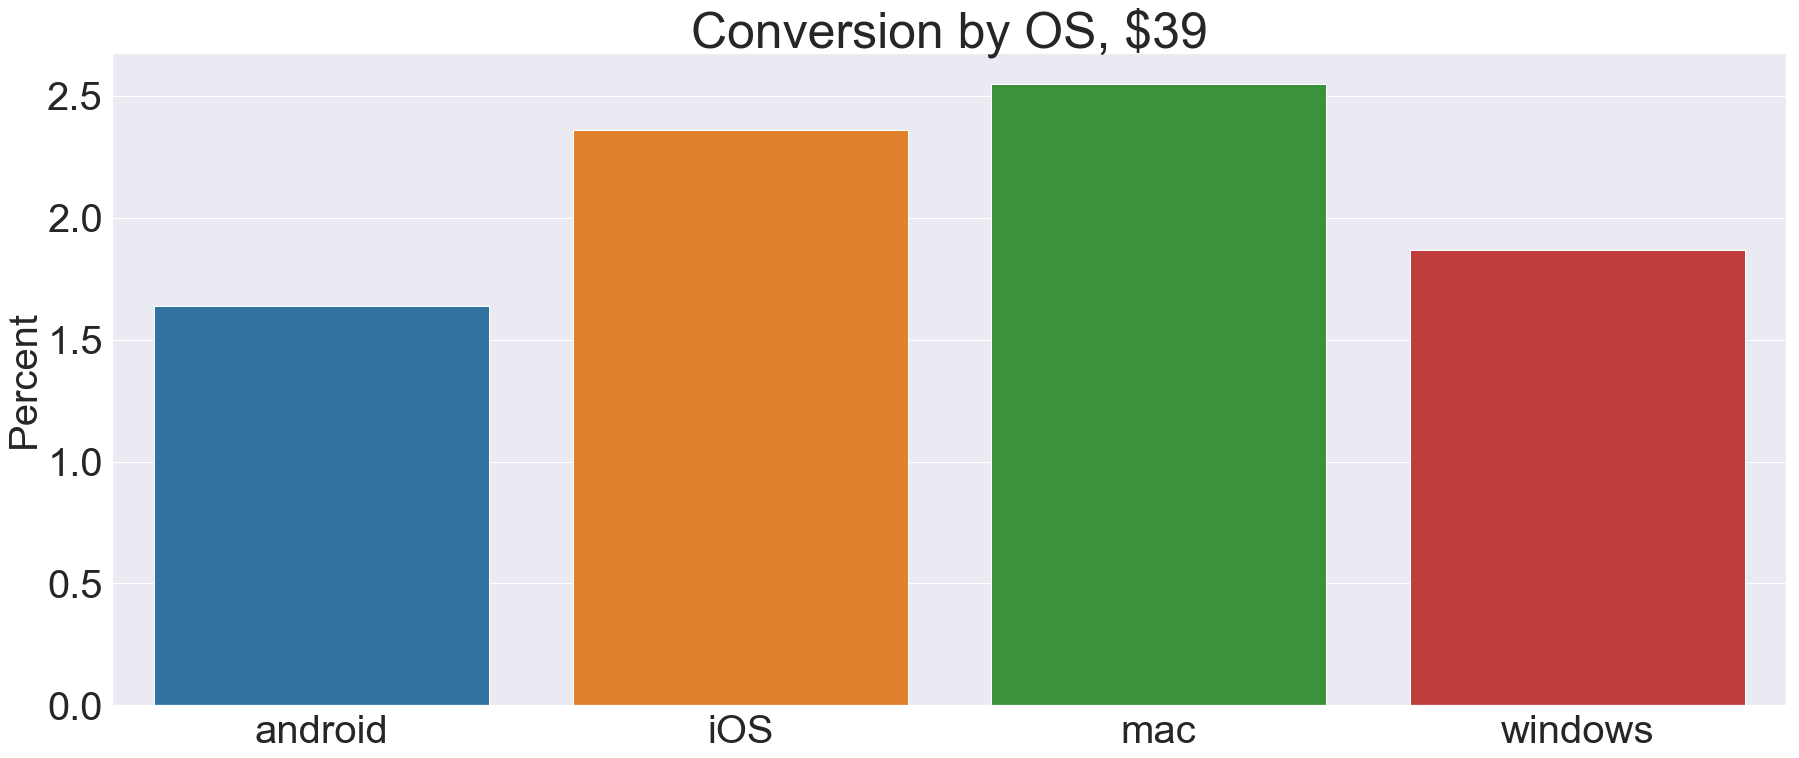

In [48]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df6.index ,y='pct', data=df6)
ax.set_title("Conversion by OS, $39", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=40)
plt.savefig("os-39-pct.png")

In [49]:
#conversion by OS $59
cv_os_xtab59=pd.crosstab(converted59['converted'],converted59['os_mod']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df7=pd.DataFrame(cv_os_xtab59.iloc[1])
df7.columns = ['pct']
df7

,pct
os_mod,
android,1.23
iOS,2.00
mac,2.12
windows,1.40


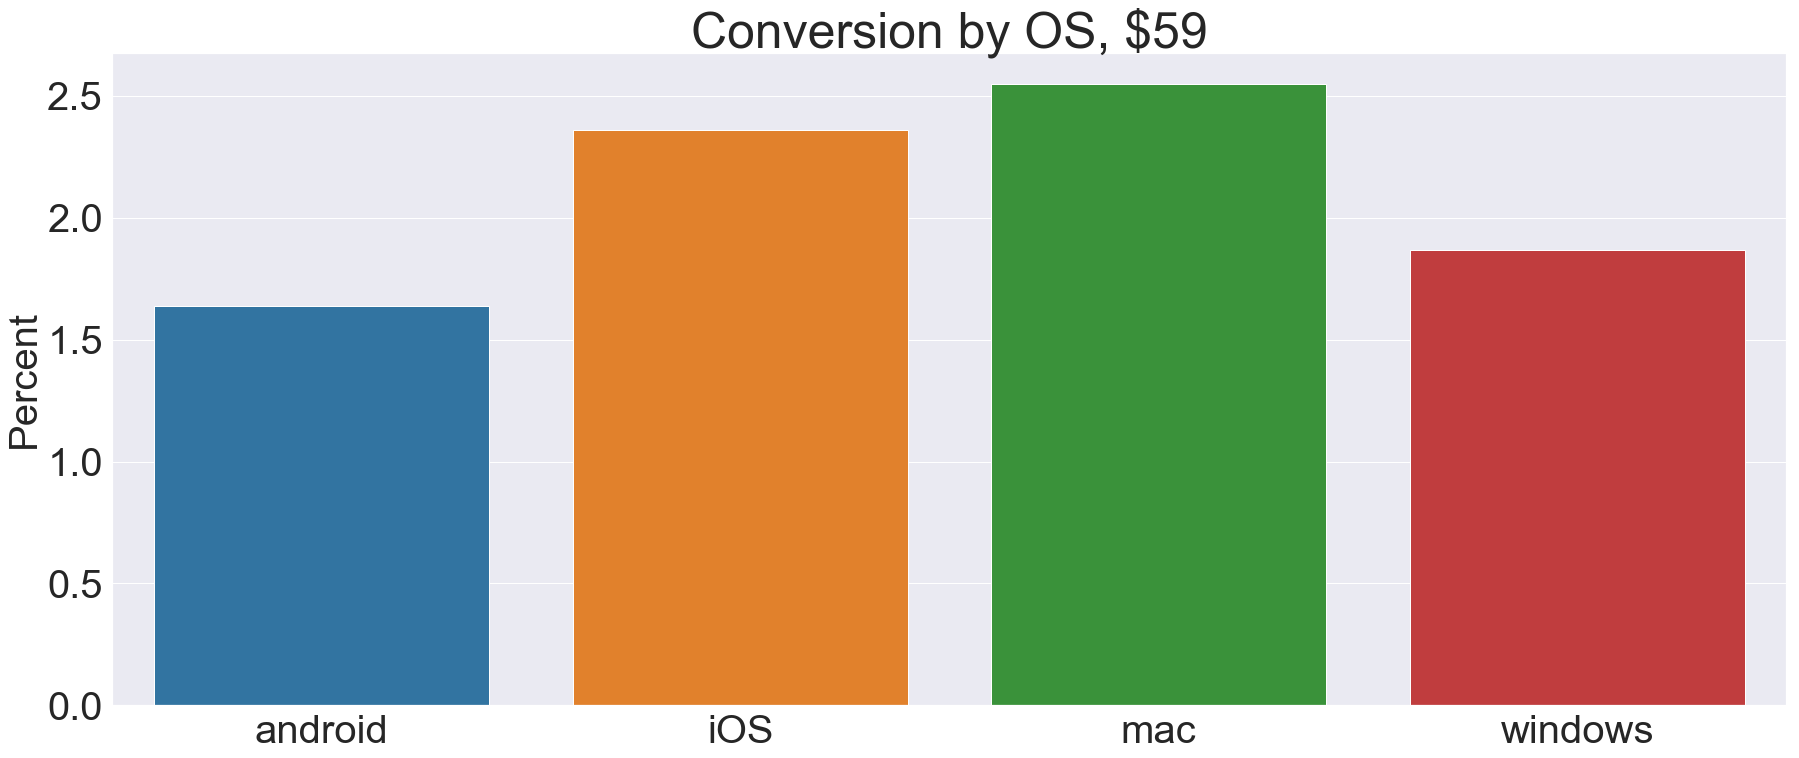

In [50]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df6.index ,y='pct', data=df6)
ax.set_title("Conversion by OS, $59", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=40)
plt.savefig("os-59-pct.png")

# referral x apple
Going back to the main data set, check out how this group performs, it might be small but friend referalls and apple users have higher rates of conversion

In [51]:
#slightly easier to two in two separate steps instead of at once
friend_apple=merged_table[merged_table['source']=='friend_referral']  #referred by friends only
friend_apple=friend_apple[friend_apple['os_mod'].isin(['iOS','mac'])]  #apple users

In [52]:
friend_apple.groupby('os_mod').count()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod
os_mod,,,,,,,,,,,,,
iOS,6326,6321,6326,6326,6326,6326,6326,6326,5497,5497,5497,5497,6326
mac,1741,1739,1741,1741,1741,1741,1741,1741,1509,1509,1509,1509,1741


In [53]:
#conversion by OS $59
friend_xtab=pd.crosstab(friend_apple['converted'],friend_apple['os_mod']).apply(lambda r: round((r/r.sum())*100,2), axis=0)
df8=pd.DataFrame(friend_xtab.iloc[1])
df8.columns = ['pct']
df8

,pct
os_mod,
iOS,4.41
mac,4.08


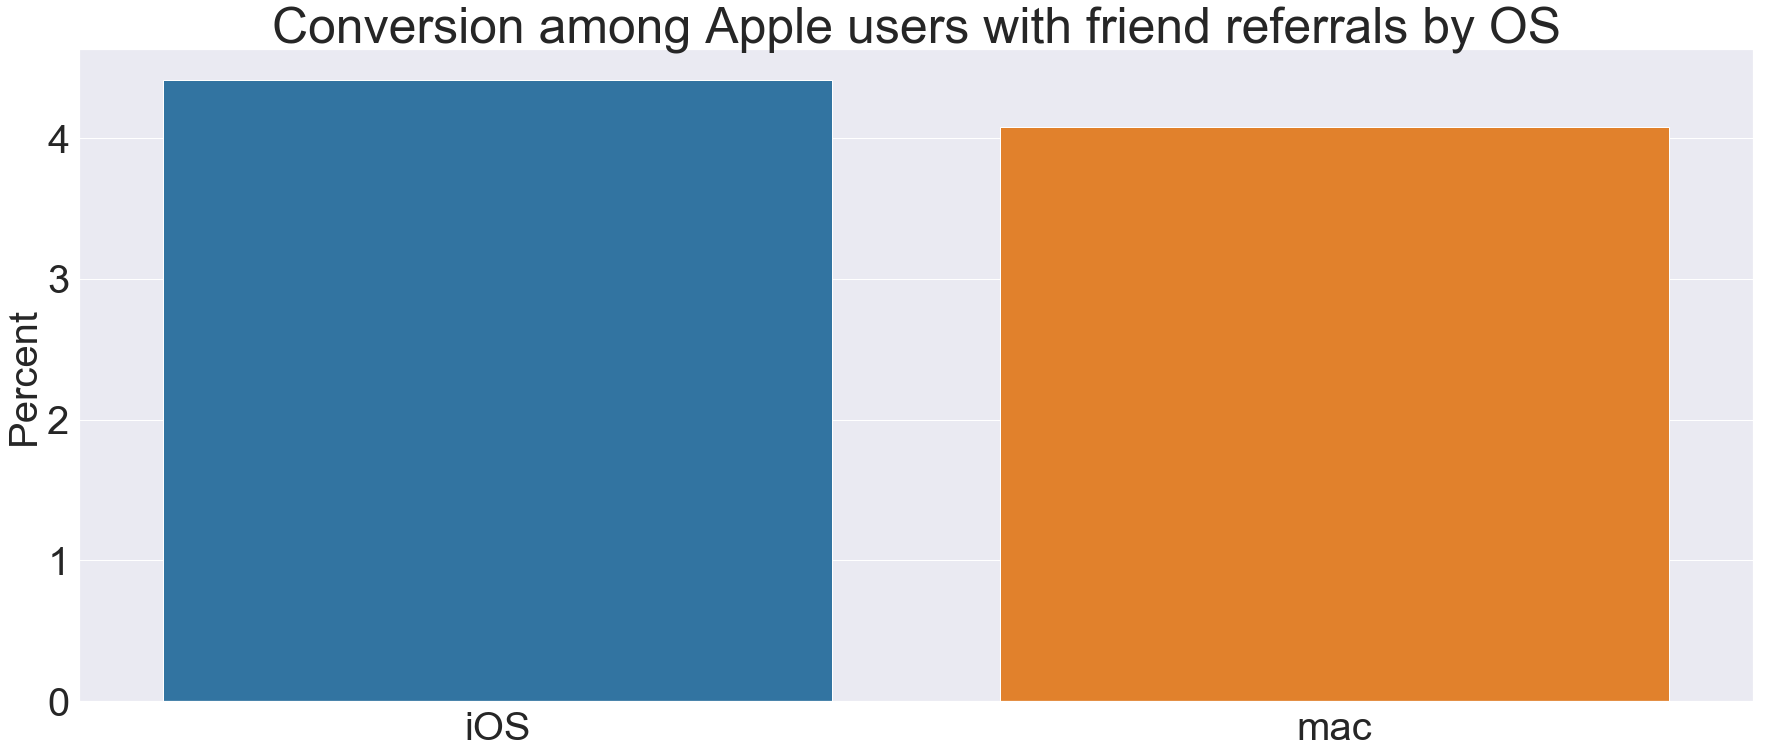

In [54]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.barplot(x=df8.index ,y='pct', data=df8)
ax.set_title("Conversion among Apple users with friend referrals by OS", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=40)
plt.savefig("applefriend.png")

In [55]:
friend_apple.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod,os_mod
263116,284439,2015-03-02 01:05:59,friend_referral,mobile,iOS,0,39.0,0,Dayton,USA,39.78,-84.20,39,iOS
212032,140032,2015-03-02 01:05:59,friend_referral,mobile,iOS,0,39.0,0,Dayton,USA,39.78,-84.20,39,iOS
113690,763697,2015-03-02 01:05:59,friend_referral,mobile,iOS,0,39.0,0,Dayton,USA,39.78,-84.20,39,iOS
200995,882904,2015-03-02 03:09:45,friend_referral,mobile,iOS,0,39.0,1,Pomona,USA,34.06,-117.76,39,iOS
269252,899442,2015-03-02 06:36:44,friend_referral,mobile,iOS,1,59.0,0,Framingham,USA,42.31,-71.44,59,iOS


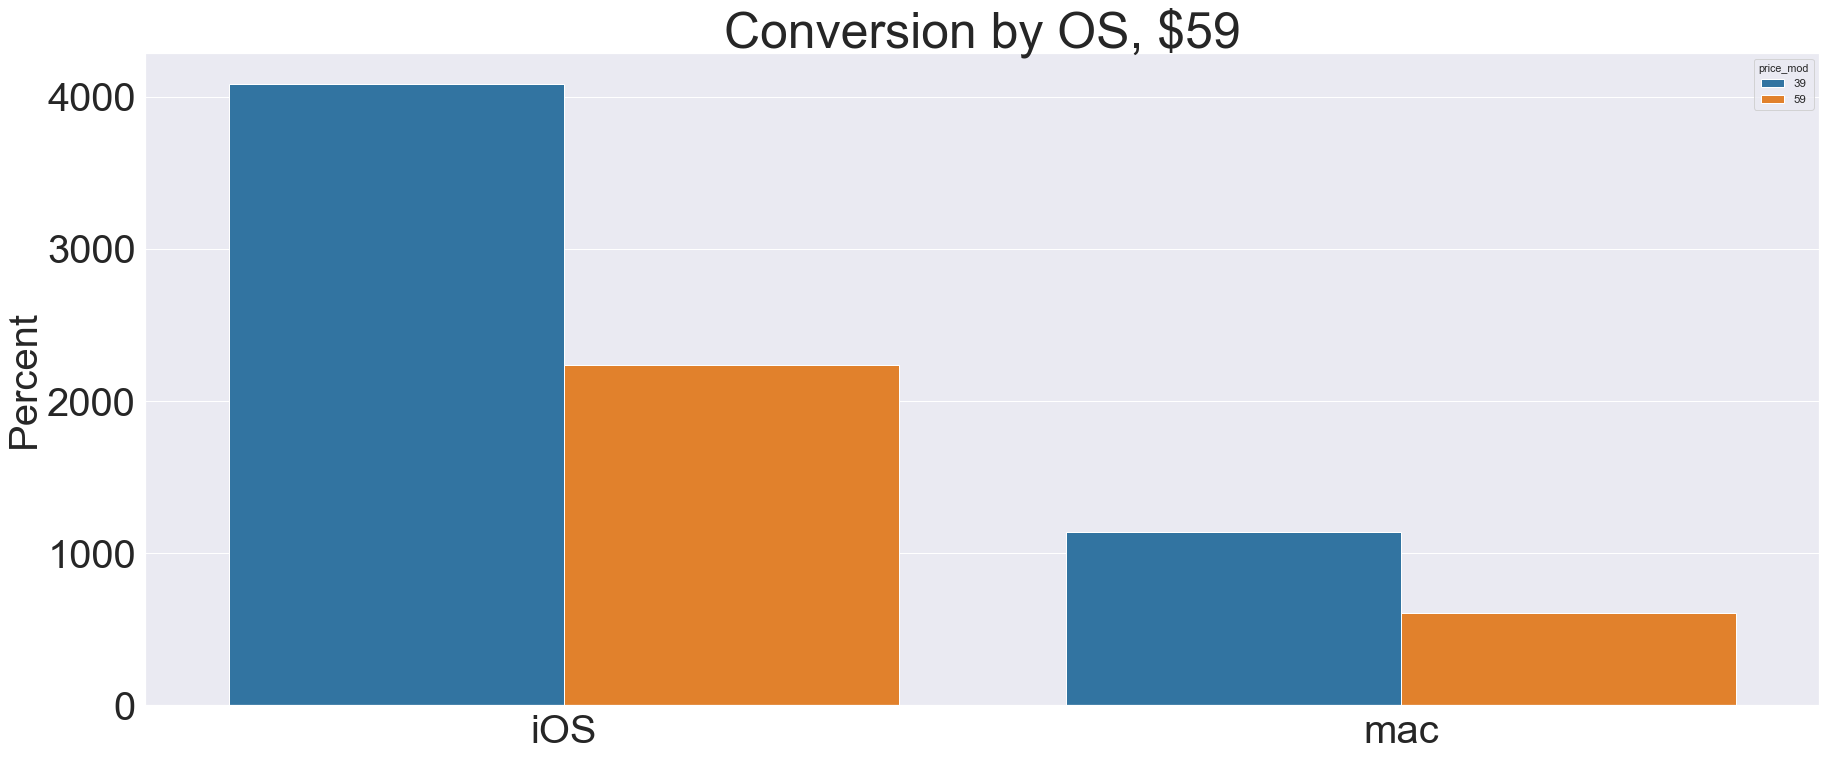

In [56]:
#price and conversion
sns.set_style('darkgrid')
sns.set_context("notebook", font_scale=1.05)
plt.figure(figsize=(30,12))
ax=sns.countplot(x='os_mod' ,hue='price_mod', data=friend_apple)
ax.set_title("Conversion by OS, $59", fontsize=50)
ax.set_xlabel("", fontsize=2)
ax.set_ylabel("Percent", fontsize=40)
ax.tick_params(labelsize=40)
#plt.savefig("os-59-pct.png")

# Moving onto looking at time varying data
We will need to see how conversion rates change over time

The timestamp column is still in object form and it needs to be changed to datetime format before we can do anything else with it. We will use the datetime function within pandas to convert this to datetime. But first, we have to handle some weird nonsensical data.

In [57]:
merged_table.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod,os_mod
166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,Plymouth,USA,45.02,-93.46,59,windows
215757,813537,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,NaN,NaN,NaN,NaN,59,windows
20240,583796,2015-03-02 00:12:40,ads_facebook,web,windows,0,39.0,0,Jacksonville,USA,30.33,-81.66,39,windows
278620,632922,2015-03-02 00:16:25,ads-google,web,windows,0,39.0,0,Virginia Beach,USA,36.74,-76.04,39,windows
271250,866803,2015-03-02 00:18:46,direct_traffic,web,mac,0,39.0,0,North Port,USA,27.05,-82.19,39,mac


Drop rows with missing timestamps. This is not ideal but also the best way to handle this data in the short term

In [58]:
merged_table_cc=merged_table.dropna(subset=['timestamp'])

Caveat with data: There's a place where the minutes is greater than 59 and in the short term it is infeasible to find it. Therefore we are getting rid of the hour minute data for now and will just focus on dates.

In [59]:
# split out just the date  (don't know why it has to run this way but it does)
merged_table_cc["date"]= merged_table_cc["timestamp"].str.split(" ")
merged_table_cc["date"]= merged_table_cc["timestamp"].str.split(" ",n = 1, expand = True)

C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Some genius accidentally input "2815" for the year 2015 so we will have to change it.

In [60]:
merged_table_cc['date']=merged_table_cc['date'].replace('2815', '2015', regex=True)

C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
merged_table_cc.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod,os_mod,date
166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,Plymouth,USA,45.02,-93.46,59,windows,2015-03-02
215757,813537,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,NaN,NaN,NaN,NaN,59,windows,2015-03-02
20240,583796,2015-03-02 00:12:40,ads_facebook,web,windows,0,39.0,0,Jacksonville,USA,30.33,-81.66,39,windows,2015-03-02
278620,632922,2015-03-02 00:16:25,ads-google,web,windows,0,39.0,0,Virginia Beach,USA,36.74,-76.04,39,windows,2015-03-02
271250,866803,2015-03-02 00:18:46,direct_traffic,web,mac,0,39.0,0,North Port,USA,27.05,-82.19,39,mac,2015-03-02


# convert to datetime and add day of week and day of month
This way, we can see if there are any weekly or monthly trends.

In [62]:
from datetime import datetime
merged_table_cc['date'] =  pd.to_datetime(merged_table_cc['date'],format="%Y-%m-%d")
merged_table_cc['day_of_week'] = merged_table_cc['date'].dt.dayofweek
merged_table_cc['day_of_month'] = merged_table_cc['date'].dt.day

C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [63]:
merged_table_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316466 entries, 166052 to 233335
Data columns (total 17 columns):
user_id             316466 non-null int64
timestamp           316466 non-null object
source              316154 non-null object
device              316466 non-null object
operative_system    296140 non-null object
test                316466 non-null int64
price               316466 non-null float64
converted           316466 non-null int64
city                275322 non-null object
country             275322 non-null object
lat                 275322 non-null float64
long                275322 non-null float64
price_mod           316466 non-null int64
os_mod              296140 non-null object
date                316466 non-null datetime64[ns]
day_of_week         316466 non-null int64
day_of_month        316466 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(7)
memory usage: 43.5+ MB


In [64]:
merged_table_cc.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,price_mod,os_mod,date,day_of_week,day_of_month
166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,Plymouth,USA,45.02,-93.46,59,windows,2015-03-02,0,2
215757,813537,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,NaN,NaN,NaN,NaN,59,windows,2015-03-02,0,2
20240,583796,2015-03-02 00:12:40,ads_facebook,web,windows,0,39.0,0,Jacksonville,USA,30.33,-81.66,39,windows,2015-03-02,0,2
278620,632922,2015-03-02 00:16:25,ads-google,web,windows,0,39.0,0,Virginia Beach,USA,36.74,-76.04,39,windows,2015-03-02,0,2
271250,866803,2015-03-02 00:18:46,direct_traffic,web,mac,0,39.0,0,North Port,USA,27.05,-82.19,39,mac,2015-03-02,0,2


# Investigate time-varying trends in conversion and traffic

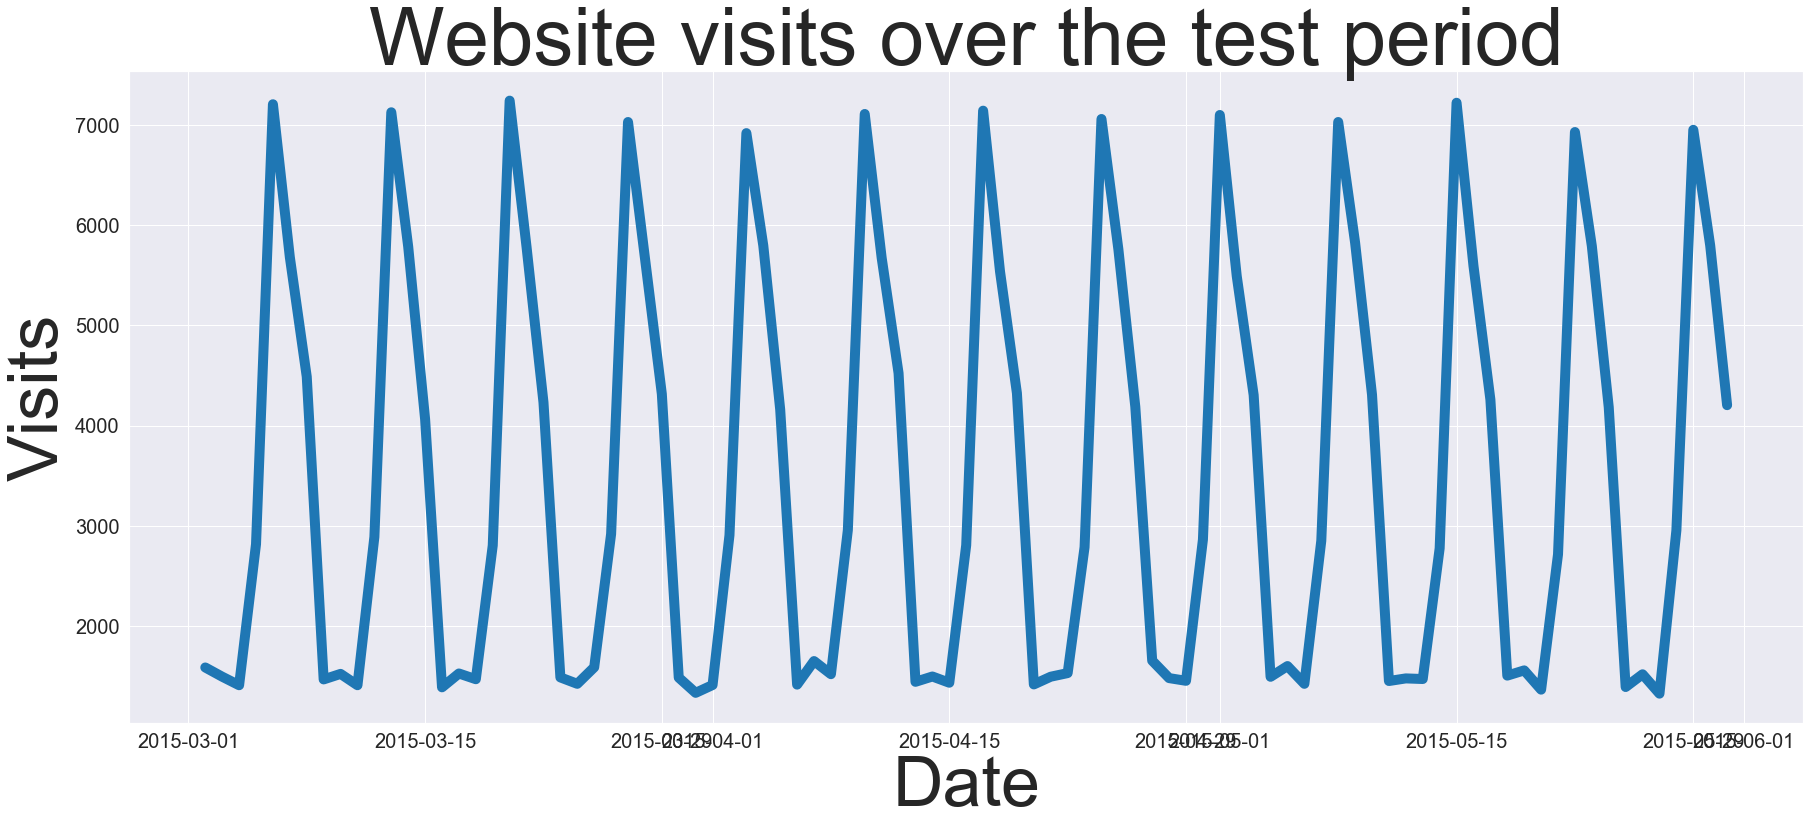

In [65]:
#this is a graph of all traffic, group by date and do total count
all_traffic= merged_table_cc.groupby('date').count()
sns.set_style('darkgrid')
paper_rc = {'lines.linewidth': 10, 'lines.markersize': 10} 
sns.set_context("notebook", font_scale=1.05, rc = paper_rc)
plt.figure(figsize=(30,12))
ax=sns.lineplot(x=all_traffic.index, y='converted', data=all_traffic)
ax.set_title("Website visits over the test period", fontsize=80)
ax.set_xlabel("Date", fontsize=70)
ax.set_ylabel("Visits", fontsize=70)
ax.tick_params(labelsize=20)
plt.savefig(r'C:\Users\Laura\Documents\Insight 2019 Docs\alltraffic.png')

# Break down data by convertion and focus on cases where people converted
We want to determine if there are weekly trends for those who converted

In [66]:
#reliminary data cleaning for those who did and those who didnt convert
merged_table_cc_no=merged_table_cc[merged_table_cc['converted']==0]
merged_table_cc_yes=merged_table_cc[merged_table_cc['converted']==1]

#groupby to aggregate by dates 
no_traffic= merged_table_cc_no.groupby('date').count()
yes_traffic= merged_table_cc_yes.groupby('date').count()

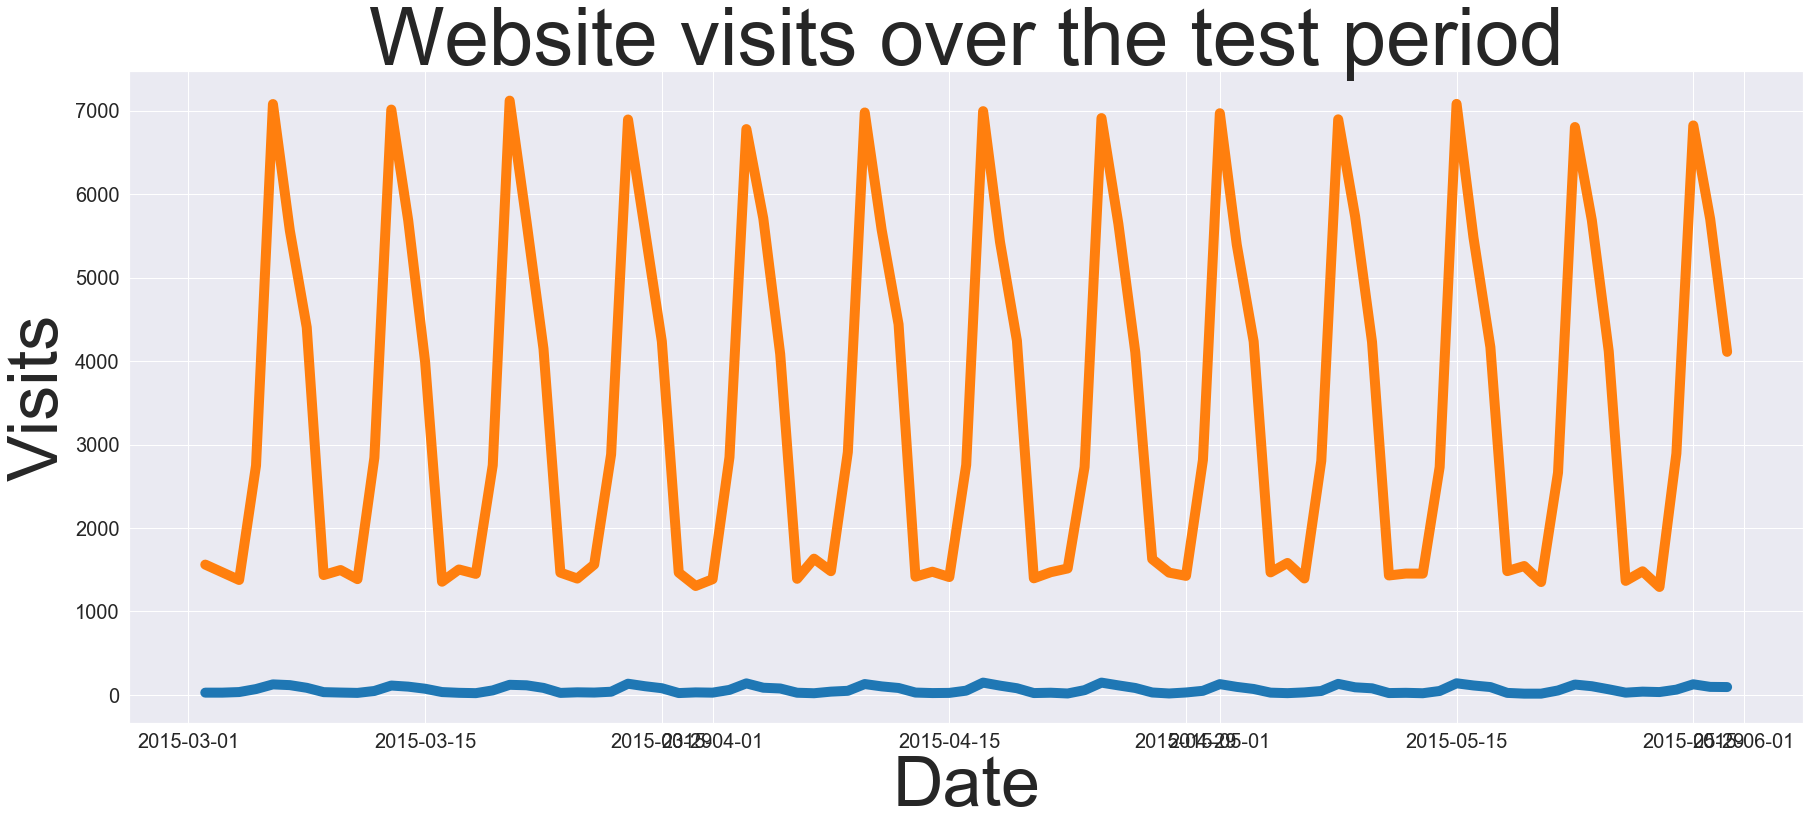

In [67]:
#this is a graph of all traffic, group by date and do total count
sns.set_style('darkgrid')
paper_rc = {'lines.linewidth': 10, 'lines.markersize': 10} 
sns.set_context("notebook", font_scale=1.05, rc = paper_rc)
plt.figure(figsize=(30,12))
ax=sns.lineplot(x=yes_traffic.index, y='converted', data=yes_traffic)
ax2=sns.lineplot(x=no_traffic.index, y='converted', data=no_traffic)
ax.set_title("Website visits over the test period", fontsize=80)
ax.set_xlabel("Date", fontsize=70)
ax.set_ylabel("Visits", fontsize=70)
ax.tick_params(labelsize=20)
#plt.savefig(r'C:\Users\Laura\Documents\Insight 2019 Docs\alltraffic.png')

We see a cyclical trend in visits and conversiosn but no longer term seasonal things.

Now we will group by day of week and day of month for each group and focus on the group that converted.

In [68]:
yes_traffic_day=merged_table_cc_yes.groupby('day_of_week').count()
yes_traffic_dom=merged_table_cc_yes.groupby('day_of_month').count()

no_traffic_day=merged_table_cc_no.groupby('day_of_week').count()
no_traffic_dom=merged_table_cc_no.groupby('day_of_month').count()

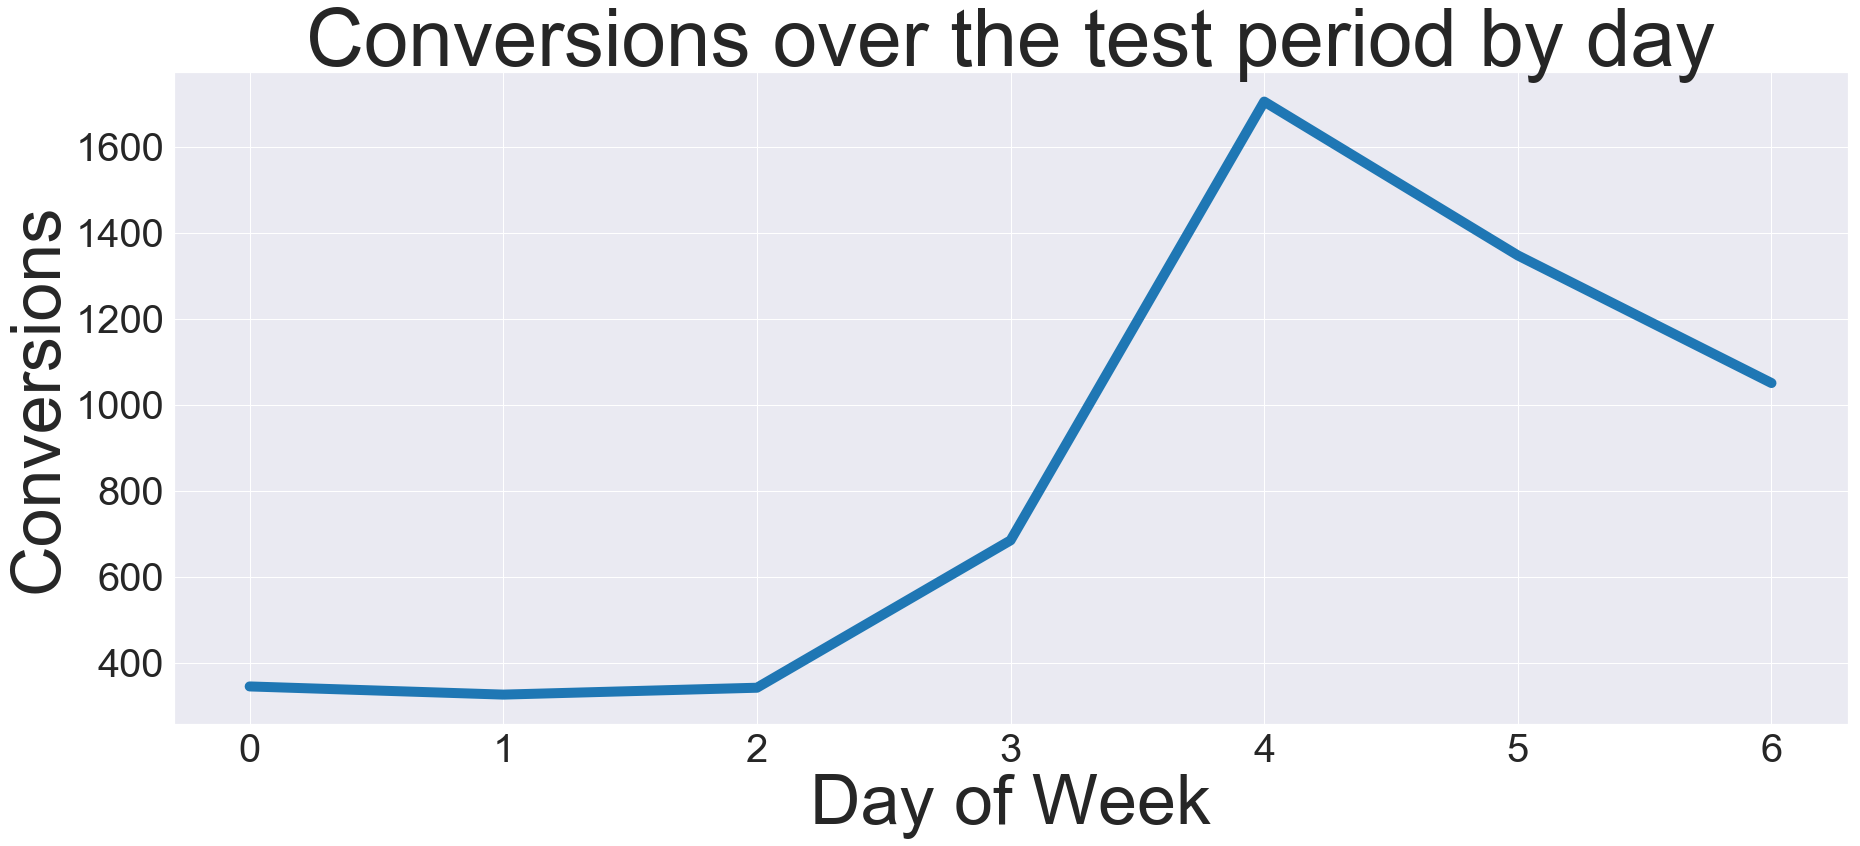

In [70]:
#this is a graph of all traffic, group by date and do total count
sns.set_style('darkgrid')
paper_rc = {'lines.linewidth': 10, 'lines.markersize': 10} 
sns.set_context("notebook", font_scale=1.05, rc = paper_rc)
plt.figure(figsize=(30,12))
ax=sns.lineplot(x=yes_traffic_day.index, y='converted', data=yes_traffic_day)
ax.set_title("Conversions over the test period by day", fontsize=80)
ax.set_xlabel("Day of Week", fontsize=70)
ax.set_ylabel("Conversions", fontsize=70)
ax.tick_params(labelsize=40)
plt.savefig(r'C:\Users\Laura\Documents\Insight 2019 Docs\yes-day.png')

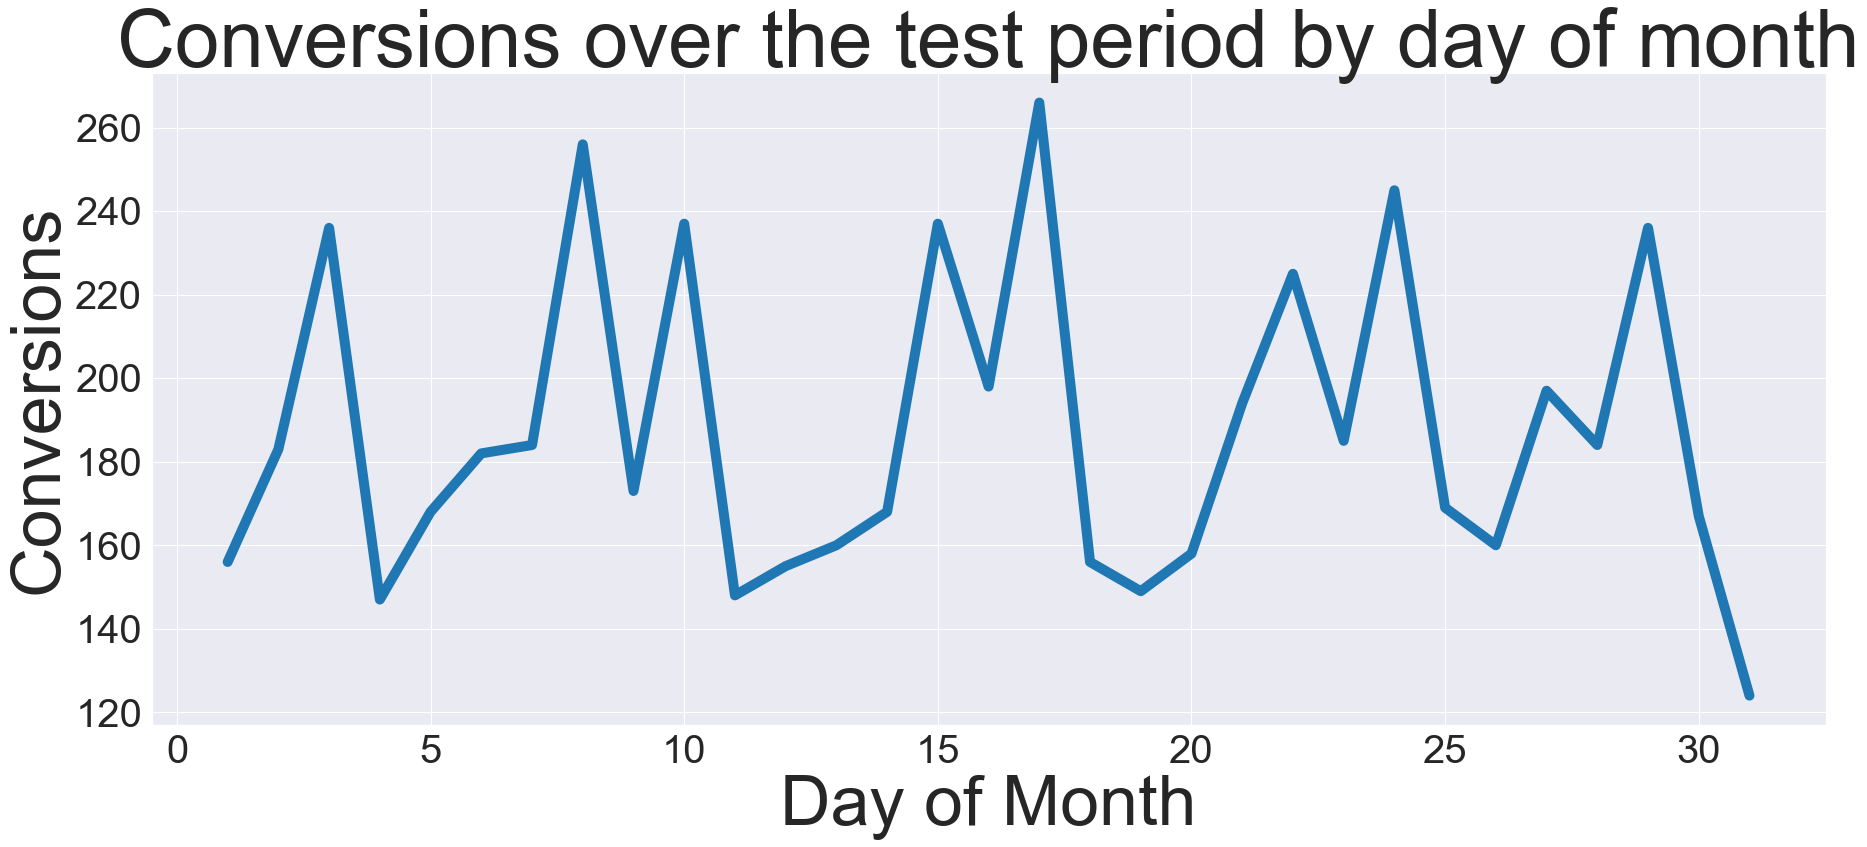

In [71]:
#this is a graph of all traffic, group by date and do total count
sns.set_style('darkgrid')
paper_rc = {'lines.linewidth': 10, 'lines.markersize': 10} 
sns.set_context("notebook", font_scale=1.05, rc = paper_rc)
plt.figure(figsize=(30,12))
ax=sns.lineplot(x=yes_traffic_dom.index, y='converted', data=yes_traffic_dom)
#ax2=sns.lineplot(x=no_traffic_dom.index, y='converted', data=no_traffic_dom)
ax.set_title("Conversions over the test period by day of month", fontsize=80)
ax.set_xlabel("Day of Month", fontsize=70)
ax.set_ylabel("Conversions", fontsize=70)
ax.tick_params(labelsize=40)
plt.savefig(r'C:\Users\Laura\Documents\Insight 2019 Docs\yes_month.png')

Conversions peak on weekend days across the whole month.

Now let's look to see if conversion is different by marketing channel across the whole week. This one is going to get a little more involved to code up.

In [73]:
yes_dow_source_xtab=pd.crosstab(merged_table_cc_yes['day_of_week'],merged_table_cc_yes['source'])
yes_dow_source_xtab

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
day_of_week,,,,,,,,,,,,
0,18,89,4,62,28,49,39,3,21,11,9,12
1,14,72,4,66,23,36,59,5,16,10,5,16
2,15,84,4,68,19,36,50,2,26,9,7,22
3,32,144,11,143,59,82,99,7,41,11,16,40
4,76,382,42,304,124,241,221,11,115,43,28,118
5,68,276,21,276,102,168,190,12,98,35,31,71
6,51,228,25,213,73,131,141,11,76,26,15,61


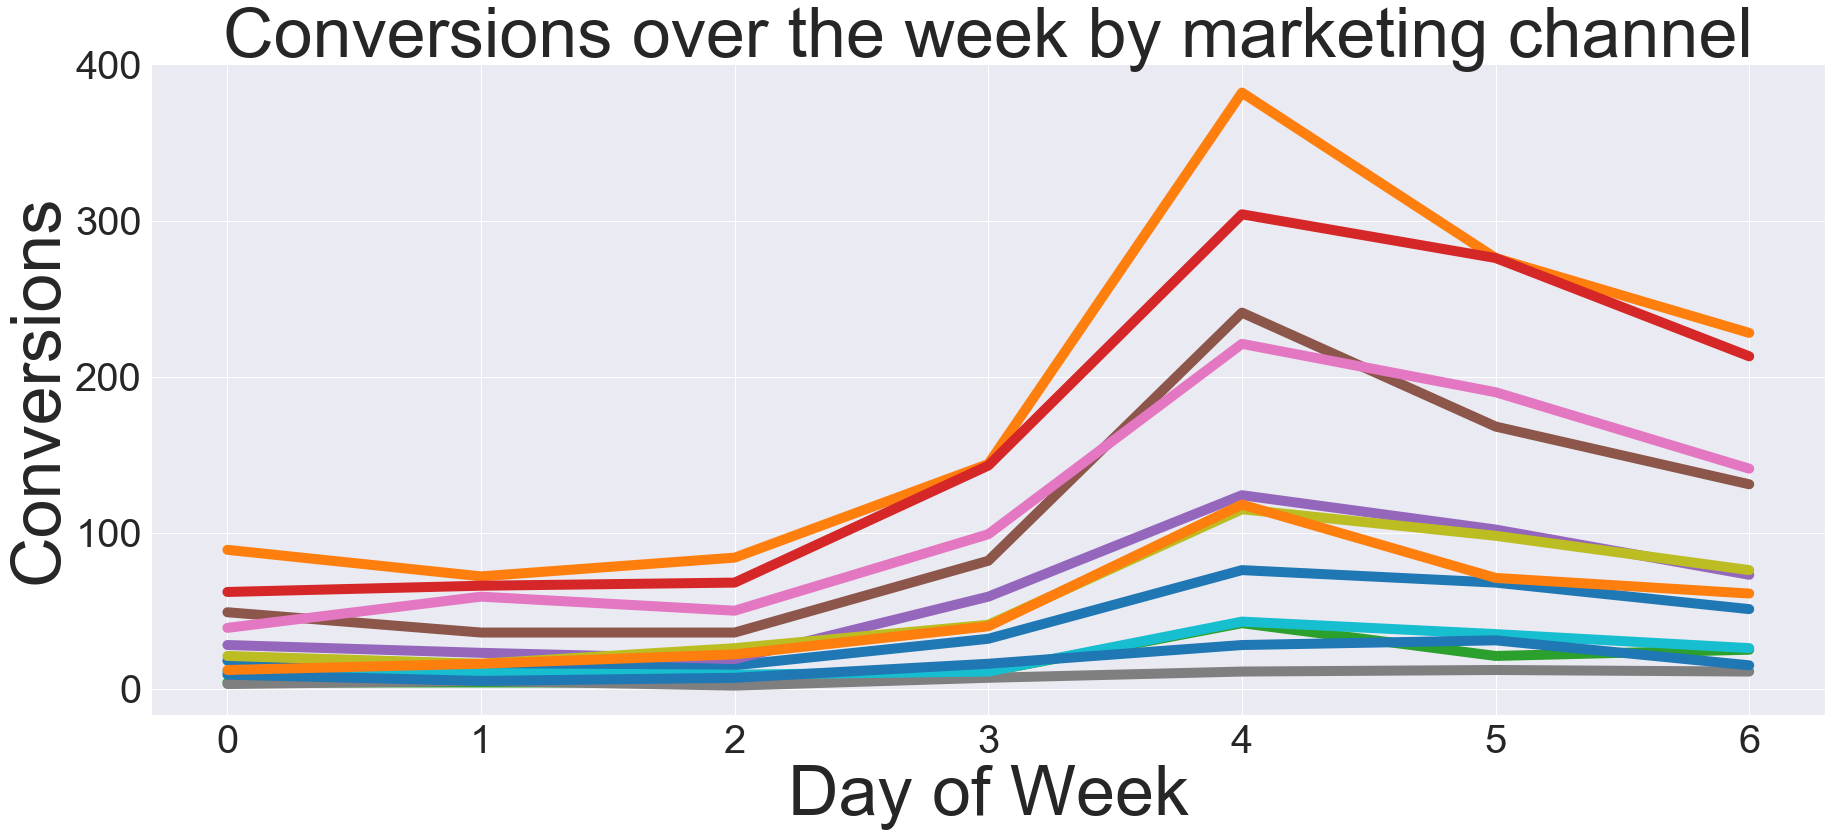

In [77]:
#this is a graph of all traffic, group by date and do total count
sns.set_style('darkgrid')
paper_rc = {'lines.linewidth': 10, 'lines.markersize': 10} 
sns.set_context("notebook", font_scale=1.05, rc = paper_rc)
plt.figure(figsize=(30,12))

ax=sns.lineplot(x=yes_dow_source_xtab.index, y='ads-bing', data=yes_dow_source_xtab)
ax2=sns.lineplot(x=yes_dow_source_xtab.index, y='ads-google', data=yes_dow_source_xtab)
ax3=sns.lineplot(x=yes_dow_source_xtab.index, y='ads-yahoo', data=yes_dow_source_xtab)
ax4=sns.lineplot(x=yes_dow_source_xtab.index, y='ads_facebook', data=yes_dow_source_xtab)
ax5=sns.lineplot(x=yes_dow_source_xtab.index, y='ads_other', data=yes_dow_source_xtab)
ax6=sns.lineplot(x=yes_dow_source_xtab.index, y='direct_traffic', data=yes_dow_source_xtab)
ax7=sns.lineplot(x=yes_dow_source_xtab.index, y='friend_referral', data=yes_dow_source_xtab)
ax8=sns.lineplot(x=yes_dow_source_xtab.index, y='seo-bing', data=yes_dow_source_xtab)
ax9=sns.lineplot(x=yes_dow_source_xtab.index, y='seo-google', data=yes_dow_source_xtab)
ax10=sns.lineplot(x=yes_dow_source_xtab.index, y='seo-other', data=yes_dow_source_xtab)
ax11=sns.lineplot(x=yes_dow_source_xtab.index, y='seo-yahoo', data=yes_dow_source_xtab)
ax12=sns.lineplot(x=yes_dow_source_xtab.index, y='seo_facebook', data=yes_dow_source_xtab)

ax.set_title("Conversions over the week by marketing channel", fontsize=70)
ax.set_xlabel("Day of Week", fontsize=70)
ax.set_ylabel("Conversions", fontsize=70)
ax.tick_params(labelsize=40)
plt.savefig(r'C:\Users\Laura\Documents\Insight 2019 Docs\yes_channel.png')

Not too many differences in this weekly pattern, although we can see that the highest conversion is still google and facebook ads.

# Key takeaways
What we've learned about conversion rates through this entire analysis:<br>
Conversion rates are highest among people who got friend referrals, although the highest numbers of converters still came from google and facebook ads<br>
Conversion rates are higher among Apple (iOS, Mac) users vs windows/android<br>
Conversion rates were higher among the group shown the lower price vs the higher price<br>
Conversion rates vary by weekday with the highest conversion occuring on weekend days. This did not change by marketing channel<br>